https://medium.com/@aaron_delarosa/portfolio-optimization-and-var-using-monte-carlo-simulation-and-scipy-optimize-b570f95673c3

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
plt.style.use("dark_background")

In [4]:
tickers = ['ADBE', 'AMD','AMZN','AAPL','GOOG','META','MSFT', 'NFLX','NVDA','TSLA']
start = datetime.datetime(2019,12, 22)
end = datetime.datetime(2023, 12, 22)
df = yf.download(tickers, start, end)['Adj Close']
df.columns = tickers

[*********************100%***********************]  10 of 10 completed


In [5]:
fig_price=px.line(df, title='Price of individual Stocks')
fig_price.show()

In [6]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio
def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]

    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])

    return results_df

In [7]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.04
results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

<ipython-input-8-ef17d99a7bb9>:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-8-ef17d99a7bb9>:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



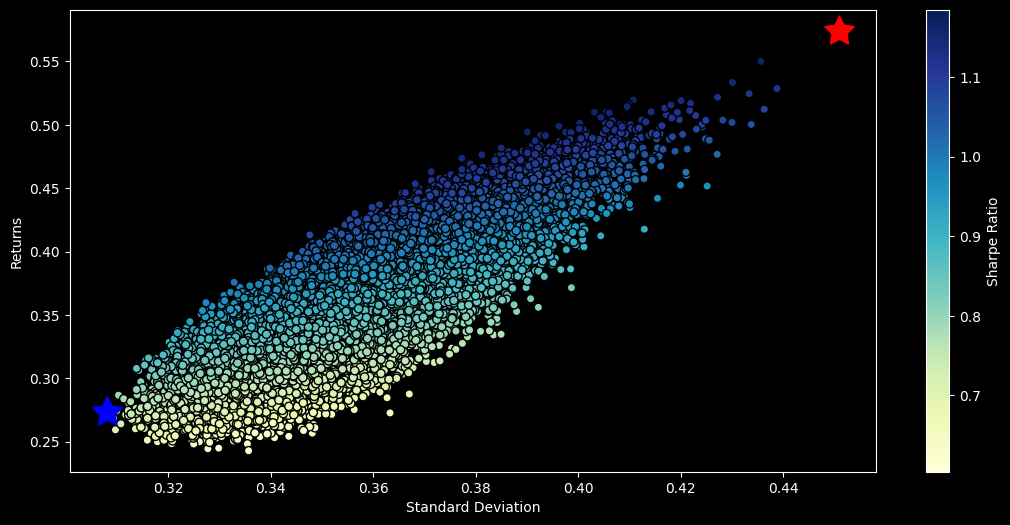

In [8]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(13,6))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe, edgecolors="black", cmap='YlGnBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe Ratio')
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500)
#plot blue star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='b',s=500)
plt.show()

In [9]:
max_sharpe_port.to_frame().T

,ret,stdev,sharpe,ADBE,AMD,AMZN,AAPL,GOOG,META,MSFT,NFLX,NVDA,TSLA
76362,0.574203,0.450984,1.184528,0.032559,0.038618,0.089933,0.033135,0.017186,0.089696,0.066081,0.007942,0.245126,0.379724


In [10]:
min_vol_port.to_frame().T

,ret,stdev,sharpe,ADBE,AMD,AMZN,AAPL,GOOG,META,MSFT,NFLX,NVDA,TSLA
25722,0.273237,0.307913,0.757475,0.24617,0.083135,0.00633,0.208655,0.200897,0.005715,0.17227,0.042978,0.031328,0.002523


In [11]:
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov, rf)

In [12]:
pd.DataFrame([round(x,2) for x in optimal_port_sharpe['x']],index=tickers).T

,ADBE,AMD,AMZN,AAPL,GOOG,META,MSFT,NFLX,NVDA,TSLA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.61,0.39


In [13]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std
def min_variance(mean_returns, cov):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
min_port_variance = min_variance(mean_returns, cov)

In [21]:
pd.DataFrame([round(x,2) for x in min_port_variance['x']],index=tickers).T

,ADBE,AMD,AMZN,AAPL,GOOG,META,MSFT,NFLX,NVDA,TSLA
0,0.29,0.0,0.0,0.1,0.28,0.0,0.26,0.06,0.0,0.0


,ADBE,AMD,AMZN,AAPL,GOOG,META,MSFT,NFLX,NVDA,TSLA
0,0.29,0.0,0.0,0.1,0.28,0.0,0.26,0.06,0.0,0.0


In [16]:
def calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var

def simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_VaR = calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]

    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])

    return results_df

In [17]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.04
days = 252
alpha = 0.05
results_frame = simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days)

<ipython-input-18-6e71b23af6e8>:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



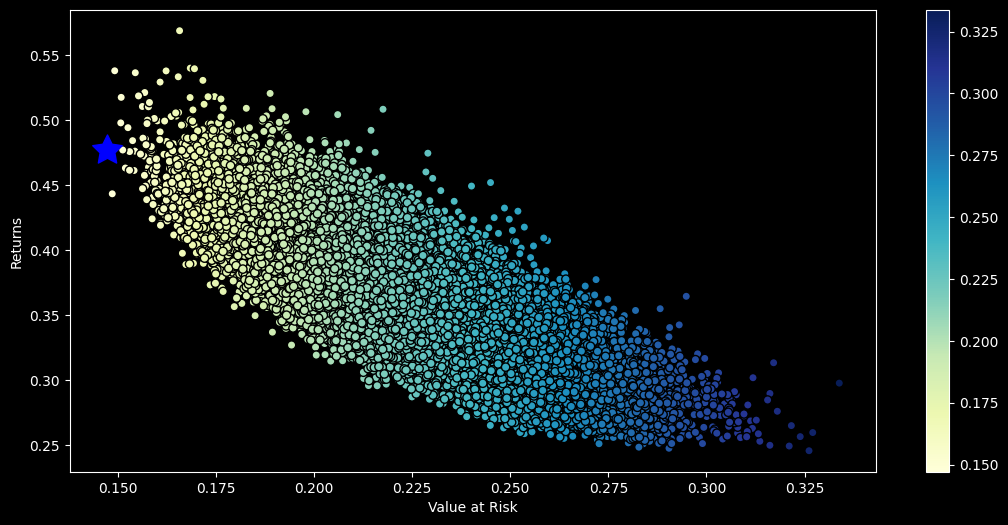

In [18]:
#locate position of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(13,6))
plt.scatter(results_frame.VaR,results_frame.ret,c=results_frame.VaR,edgecolors="black",cmap='YlGnBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()
#plot blue star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='b',s=500)
plt.show()

In [19]:
min_VaR_port.to_frame().T

,ret,stdev,VaR,ADBE,AMD,AMZN,AAPL,GOOG,META,MSFT,NFLX,NVDA,TSLA
83019,0.477025,0.379431,0.147084,0.274274,0.006963,0.039974,0.001388,0.000548,0.034876,0.189129,0.041543,0.199313,0.211991


<ipython-input-20-857f21e0514b>:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



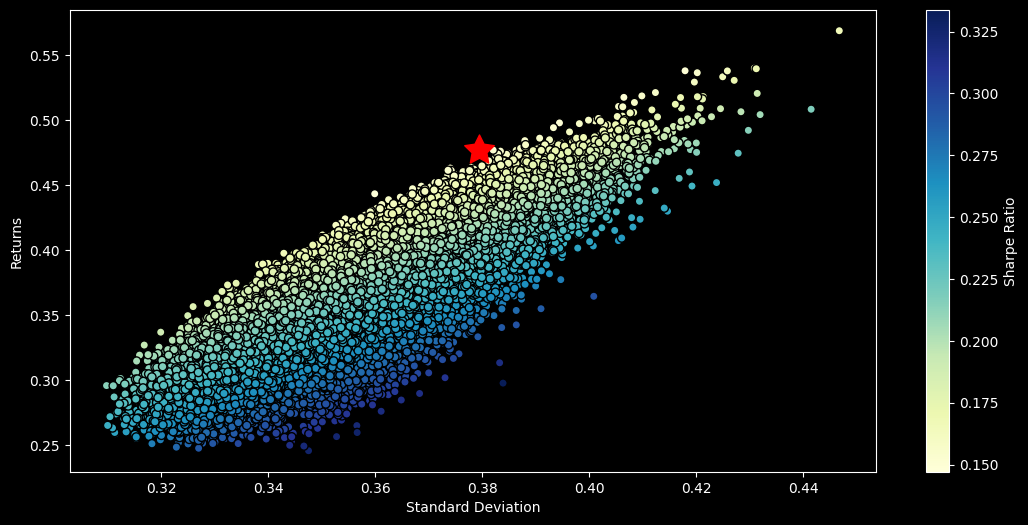

In [20]:
#locate position of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(13,6))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.VaR,edgecolors="black",cmap='YlGnBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe Ratio')
#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[1],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()

In [22]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var
def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
min_port_VaR = min_VaR(mean_returns, cov, alpha, days)

In [25]:
pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=tickers).T

,ADBE,AMD,AMZN,AAPL,GOOG,META,MSFT,NFLX,NVDA,TSLA
0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.42,0.27
